In [ ]:
!pip install -q mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [ ]:
!pip install -q "opencv-python-headless>4.3"

In [ ]:
# Import libraries
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import PIL

import tensorflow as tf
import tensorflow_hub as hub
import tqdm

mpl.rcParams.update({
    'font.size': 10,
})


In [ ]:
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

9209/9209 [==============================] - 0s 0us/step


array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging'], dtype='<U49')

In [ ]:
jumpingjack_url = 'https://github.com/tensorflow/models/raw/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/jumpingjack.gif'
jumpingjack_path = tf.keras.utils.get_file(
    fname='jumpingjack.gif',
    origin=jumpingjack_url,
    cache_dir='.', cache_subdir='.',
)

783318/783318 [==============================] - 0s 0us/step


In [ ]:
# Read and process a video
def load_gif(file_path, image_size=(224, 224)):
  """Loads a gif file into a TF tensor.

  Use images resized to match what's expected by your model.
  The model pages say the "A2" models expect 224 x 224 images at 5 fps

  Args:
    file_path: path to the location of a gif file.
    image_size: a tuple of target size.

  Returns:
    a video of the gif file
  """
  # Load a gif file, convert it to a TF tensor
  raw = tf.io.read_file(file_path)
  video = tf.io.decode_gif(raw)
  # Resize the video
  video = tf.image.resize(video, image_size)
  # change dtype to a float32
  # Hub models always want images normalized to [0,1]
  # ref: https://www.tensorflow.org/hub/common_signatures/images#input
  video = tf.cast(video, tf.float32) / 255.
  return video

In [ ]:
jumpingjack=load_gif(jumpingjack_path)
jumpingjack.shape

TensorShape([13, 224, 224, 3])

In [ ]:
%%time
id = 'a2'
mode = 'base'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: user 19.9 s, sys: 929 ms, total: 20.8 s
Wall time: 22.4 s


In [ ]:
sig = model.signatures['serving_default']
print(sig.pretty_printed_signature())

signature_wrapper(*, image)
  Args:
    image: float32 Tensor, shape=(None, None, None, None, 3)
  Returns:
    {'classifier_head': <1>}
      <1>: float32 Tensor, shape=(None, 600)


In [ ]:
#warmup
sig(image = jumpingjack[tf.newaxis, :1]);

In [ ]:
%%time
logits = sig(image = jumpingjack[tf.newaxis, ...])
logits = logits['classifier_head'][0]

print(logits.shape)
print()

(600,)

CPU times: user 37.7 s, sys: 169 ms, total: 37.9 s
Wall time: 29.2 s


In [ ]:
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

In [ ]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

jumping jacks       : 0.834
zumba               : 0.008
lunge               : 0.003
doing aerobics      : 0.003
polishing metal     : 0.002


**The streaming model**

Phần trước sử dụng một mô hình chạy trên toàn bộ video. Thường khi xử lý một video, bạn không muốn chỉ có một dự đoán duy nhất ở cuối, mà bạn muốn cập nhật dự đoán từng khung hình. Các phiên bản stream của mô hình cho phép bạn làm điều này.

Hãy tải phiên bản stream của mô hình lên.

In [ ]:
%%time
id = 'a2'
mode = 'stream'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: user 57.7 s, sys: 2.83 s, total: 1min
Wall time: 1min 1s


Đoạn code `list(model.signatures.keys())` được sử dụng để lấy danh sách các chữ ký (signatures) của mô hình.

In [ ]:
list(model.signatures.keys())

['call', 'init_states']

"Nghĩa là chữ ký `init_states` nhận đầu vào là hình dạng của video (batch, frames, height, width, colors) và trả về một từ điển lớn chứa các tensor chứa trạng thái ban đầu của RNNs."

In [ ]:
lines = model.signatures['init_states'].pretty_printed_signature().splitlines()
lines = lines[:10]
lines.append('      ...')
print('.\n'.join(lines))

signature_wrapper(*, input_shape).
  Args:.
    input_shape: int32 Tensor, shape=(5,).
  Returns:.
    {'state/b0/l0/pool_buffer': <1>, 'state/b0/l0/pool_frame_count': <2>, 'state/b0/l1/pool_buffer': <3>, 'state/b0/l1/pool_frame_count': <4>, 'state/b0/l1/stream_buffer': <5>, 'state/b0/l2/pool_buffer': <6>, 'state/b0/l2/pool_frame_count': <7>, 'state/b0/l2/stream_buffer': <8>, 'state/b1/l0/pool_buffer': <9>, 'state/b1/l0/pool_frame_count': <10>, 'state/b1/l0/stream_buffer': <11>, 'state/b1/l1/pool_buffer': <12>, 'state/b1/l1/pool_frame_count': <13>, 'state/b1/l1/stream_buffer': <14>, 'state/b1/l2/pool_buffer': <15>, 'state/b1/l2/pool_frame_count': <16>, 'state/b1/l2/stream_buffer': <17>, 'state/b1/l3/pool_buffer': <18>, 'state/b1/l3/pool_frame_count': <19>, 'state/b1/l3/stream_buffer': <20>, 'state/b1/l4/pool_buffer': <21>, 'state/b1/l4/pool_frame_count': <22>, 'state/b1/l4/stream_buffer': <23>, 'state/b2/l0/pool_buffer': <24>, 'state/b2/l0/pool_frame_count': <25>, 'state/b2/l0/stream_b

In [ ]:
initial_state = model.init_states(jumpingjack[tf.newaxis, ...].shape)

"Dòng code `initial_state = model.init_states(jumpingjack[tf.newaxis, ...].shape)` có nghĩa là chúng ta sử dụng phương thức `init_states` của mô hình để lấy trạng thái ban đầu cho mạng RNNs dựa trên hình dạng của dữ liệu video `jumpingjack`. Dữ liệu video `jumpingjack` được mở rộng thêm một chiều với `tf.newaxis` để tạo ra một batch duy nhất. Sau đó, chúng ta truyền hình dạng của video đã được mở rộng này vào phương thức `init_states` để lấy trạng thái ban đầu của mạng RNNs."

In [ ]:
type(initial_state)

dict

In [ ]:
list(sorted(initial_state.keys()))[:5]

['state/b0/l0/pool_buffer',
 'state/b0/l0/pool_frame_count',
 'state/b0/l1/pool_buffer',
 'state/b0/l1/pool_frame_count',
 'state/b0/l1/stream_buffer']

Sau khi có trạng thái ban đầu cho các mạng RNN, bạn có thể truyền trạng thái và một khung hình video làm đầu vào (duy trì hình dạng (batch, frames, height, width, colors) cho khung hình video). Mô hình trả về một cặp (logits, state).

Sau khi chỉ xem khung hình đầu tiên, mô hình chưa tin rằng video này là "jumping jacks":

In [ ]:
inputs = initial_state.copy()

# Add the batch axis, take the first frme, but keep the frame-axis.
inputs['image'] = jumpingjack[tf.newaxis, 0:1, ...]

In [ ]:
# warmup
model(inputs);

In [ ]:
logits, new_state = model(inputs)
logits = logits[0]
probs = tf.nn.softmax(logits, axis=-1)

for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

print()

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039



In [ ]:
%%time
state = initial_state.copy()
all_logits = []

for n in range(len(jumpingjack)):
  inputs = state
  inputs['image'] = jumpingjack[tf.newaxis, n:n+1, ...]
  result, state = model(inputs)
  all_logits.append(logits)

probabilities = tf.nn.softmax(all_logits, axis=-1)

CPU times: user 1.93 s, sys: 85.9 ms, total: 2.02 s
Wall time: 2.52 s


In [ ]:
for label, p in get_top_k(probabilities[-1]):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


Nếu bạn chạy mô hình trong một vòng lặp, truyền trạng thái đã cập nhật cùng với mỗi khung hình, mô hình sẽ nhanh chóng hội tụ đến kết quả chính xác:

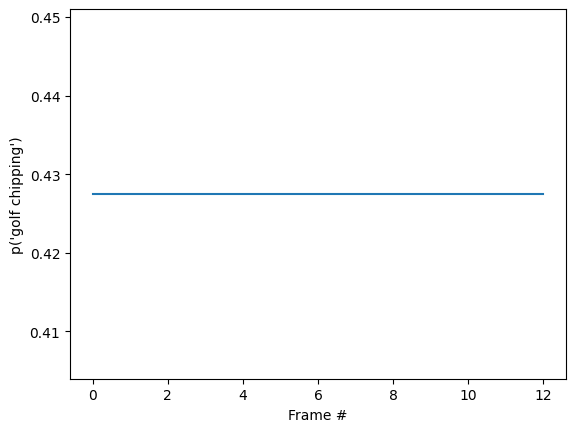

In [ ]:
id = tf.argmax(probabilities[-1])
plt.plot(probabilities[:, id])
plt.xlabel('Frame #')
plt.ylabel(f"p('{KINETICS_600_LABELS[id]}')");

Bạn có thể nhận thấy rằng xác suất cuối cùng có độ chắc chắn cao hơn nhiều so với phần trước khi chạy mô hình cơ bản. Mô hình cơ bản trả về một trung bình của các dự đoán trên các khung hình.

In [ ]:
for label, p in get_top_k(tf.reduce_mean(probabilities, axis=0)):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.427
tackling            : 0.134
lunge               : 0.056
stretching arm      : 0.053
passing american football (not in game): 0.039


**Animate the predictions over time**

Phần trước đã giải thích một số chi tiết về cách sử dụng các mô hình này. Phần này sẽ dựa trên những thông tin đó để tạo ra một số đoạn hoạt hình suy luận đẹp mắt.

Bên dưới định nghĩa các hàm trợ giúp được sử dụng trong phần này.

In [ ]:
# Get top_k labels and probabilities predicted using MoViNets streaming model
def get_top_k_streaming_labels(probs, k=5, label_map=KINETICS_600_LABELS):
  """Returns the top-k labels over an entire video sequence.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k probabilities, labels, and logit indices
  """
  top_categories_last = tf.argsort(probs, -1, 'DESCENDING')[-1, :1]
  # Sort predictions to find top_k
  categories = tf.argsort(probs, -1, 'DESCENDING')[:, :k]
  categories = tf.reshape(categories, [-1])

  counts = sorted([
      (i.numpy(), tf.reduce_sum(tf.cast(categories == i, tf.int32)).numpy())
      for i in tf.unique(categories)[0]
  ], key=lambda x: x[1], reverse=True)

  top_probs_idx = tf.constant([i for i, _ in counts[:k]])
  top_probs_idx = tf.concat([top_categories_last, top_probs_idx], 0)
  # find unique indices of categories
  top_probs_idx = tf.unique(top_probs_idx)[0][:k+1]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_probs_idx, axis=-1)
  top_probs = tf.transpose(top_probs, perm=(1, 0))
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_probs_idx, axis=0)
  # decode the top_k labels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]

  return top_probs, top_labels, top_probs_idx

# Plot top_k predictions at a given time step
def plot_streaming_top_preds_at_step(
    top_probs,
    top_labels,
    step=None,
    image=None,
    legend_loc='lower left',
    duration_seconds=10,
    figure_height=500,
    playhead_scale=0.8,
    grid_alpha=0.3):
  """Generates a plot of the top video model predictions at a given time step.

  Args:
    top_probs: a tensor of shape (k, num_frames) representing the top-k
      probabilities over all frames.
    top_labels: a list of length k that represents the top-k label strings.
    step: the current time step in the range [0, num_frames].
    image: the image frame to display at the current time step.
    legend_loc: the placement location of the legend.
    duration_seconds: the total duration of the video.
    figure_height: the output figure height.
    playhead_scale: scale value for the playhead.
    grid_alpha: alpha value for the gridlines.

  Returns:
    A tuple of the output numpy image, figure, and axes.
  """
  # find number of top_k labels and frames in the video
  num_labels, num_frames = top_probs.shape
  if step is None:
    step = num_frames
  # Visualize frames and top_k probabilities of streaming video
  fig = plt.figure(figsize=(6.5, 7), dpi=300)
  gs = mpl.gridspec.GridSpec(8, 1)
  ax2 = plt.subplot(gs[:-3, :])
  ax = plt.subplot(gs[-3:, :])
  # display the frame
  if image is not None:
    ax2.imshow(image, interpolation='nearest')
    ax2.axis('off')
  # x-axis (frame number)
  preview_line_x = tf.linspace(0., duration_seconds, num_frames)
  # y-axis (top_k probabilities)
  preview_line_y = top_probs

  line_x = preview_line_x[:step+1]
  line_y = preview_line_y[:, :step+1]

  for i in range(num_labels):
    ax.plot(preview_line_x, preview_line_y[i], label=None, linewidth='1.5',
            linestyle=':', color='gray')
    ax.plot(line_x, line_y[i], label=top_labels[i], linewidth='2.0')


  ax.grid(which='major', linestyle=':', linewidth='1.0', alpha=grid_alpha)
  ax.grid(which='minor', linestyle=':', linewidth='0.5', alpha=grid_alpha)

  min_height = tf.reduce_min(top_probs) * playhead_scale
  max_height = tf.reduce_max(top_probs)
  ax.vlines(preview_line_x[step], min_height, max_height, colors='red')
  ax.scatter(preview_line_x[step], max_height, color='red')

  ax.legend(loc=legend_loc)

  plt.xlim(0, duration_seconds)
  plt.ylabel('Probability')
  plt.xlabel('Time (s)')
  plt.yscale('log')

  fig.tight_layout()
  fig.canvas.draw()

  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  plt.close()

  figure_width = int(figure_height * data.shape[1] / data.shape[0])
  image = PIL.Image.fromarray(data).resize([figure_width, figure_height])
  image = np.array(image)

  return image

# Plotting top_k predictions from MoViNets streaming model
def plot_streaming_top_preds(
    probs,
    video,
    top_k=5,
    video_fps=25.,
    figure_height=500,
    use_progbar=True):
  """Generates a video plot of the top video model predictions.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    video: the video to display in the plot.
    top_k: the number of top predictions to select.
    video_fps: the input video fps.
    figure_fps: the output video fps.
    figure_height: the height of the output video.
    use_progbar: display a progress bar.

  Returns:
    A numpy array representing the output video.
  """
  # select number of frames per second
  video_fps = 8.
  # select height of the image
  figure_height = 500
  # number of time steps of the given video
  steps = video.shape[0]
  # estimate duration of the video (in seconds)
  duration = steps / video_fps
  # estiamte top_k probabilities and corresponding labels
  top_probs, top_labels, _ = get_top_k_streaming_labels(probs, k=top_k)

  images = []
  step_generator = tqdm.trange(steps) if use_progbar else range(steps)
  for i in step_generator:
    image = plot_streaming_top_preds_at_step(
        top_probs=top_probs,
        top_labels=top_labels,
        step=i,
        image=video[i],
        duration_seconds=duration,
        figure_height=figure_height,
    )
    images.append(image)

  return np.array(images)

Bắt đầu bằng việc chạy mô hình streaming qua các khung hình của video và thu thập các logits:

In [ ]:
init_states = model.init_states(jumpingjack[tf.newaxis].shape)

In [ ]:
# Insert your video clip here
video = jumpingjack
images = tf.split(video[tf.newaxis], video.shape[0], axis=1)

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for image in tqdm.tqdm(images):
  # predictions for each frame
  logits, states = model({**states, 'image': image})
  all_logits.append(logits)

# concatinating all the logits
logits = tf.concat(all_logits, 0)
# estimating probabilities
probs = tf.nn.softmax(logits, axis=-1)

100%|██████████| 13/13 [00:01<00:00,  8.77it/s]


In [ ]:
final_probs = probs[-1]
print('Top_k predictions and their probablities\n')
for label, p in get_top_k(final_probs):
  print(f'{label:20s}: {p:.3f}')

Top_k predictions and their probablities

jumping jacks       : 0.999
zumba               : 0.000
doing aerobics      : 0.000
dancing charleston  : 0.000
slacklining         : 0.000


Chuyển đổi chuỗi xác suất thành một video:

In [ ]:
# Generate a plot and output to a video tensor
plot_video = plot_streaming_top_preds(probs, video, video_fps=8.)

100%|██████████| 13/13 [00:10<00:00,  1.29it/s]


In [ ]:
# For gif format, set codec='gif'
media.show_video(plot_video, fps=3)